## MMD ResNet for RNA data

Use GTEX as source and TCGA as target since there are 2445 GTEX samples and only 683 TCGA samples

### Imports

In [4]:
import os.path
import keras.optimizers
from Calibration_Util import DataHandler as dh 
from Calibration_Util import FileIO as io
from keras.layers import Input, Dense, merge, Activation, add
from keras.models import Model
from keras import callbacks as cb
import numpy as np
import matplotlib
from keras.layers.normalization import BatchNormalization
#detect display
import os
havedisplay = "DISPLAY" in os.environ
#if we have a display use a plotting backend
if havedisplay:
    matplotlib.use('TkAgg')
else:
    matplotlib.use('Agg')

import CostFunctions as cf
import Monitoring as mn
from keras.regularizers import l2
from sklearn import decomposition
from keras.callbacks import LearningRateScheduler
import math
import ScatterHist as sh
from keras import initializers
from numpy import genfromtxt
import sklearn.preprocessing as prep
import tensorflow as tf
import keras.backend as K

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Configure hyperparameters

In [5]:
mmdNetLayerSizes = [20, 20]
l2_penalty = 1e-2

### Load Data

In [6]:
sourcePath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch1-gtex-20PCs.csv')
targetPath = os.path.join(io.DeepLearningRoot(), 'data/rnaBatch2-tcga-20PCs.csv')

In [7]:
source = genfromtxt(sourcePath, delimiter=',', skip_header=1)
target = genfromtxt(targetPath, delimiter=',', skip_header=1)
inputDim = target.shape[1]
inputDim

20

In [8]:
print("gtex = source shape = " + str(source.shape))
print("tcga = target shape = " + str(target.shape))

gtex = source shape = (239, 20)
tcga = target shape = (229, 20)


### Build MMD Net

In [8]:
# input
calibInput = Input(shape=(inputDim, ))

# block 1
block1_bn1 = BatchNormalization()(calibInput)
block1_a1 = Activation('relu')(block1_bn1)
block1_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a1)
block1_bn2 = BatchNormalization()(block1_w1)
block1_a2 = Activation('relu')(block1_bn2)
block1_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block1_a2)
block1_output = add([block1_w2, calibInput])

# block 2
block2_bn1 = BatchNormalization()(block1_output)
block2_a1 = Activation('relu')(block2_bn1)
block2_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a1)
block2_bn2 = BatchNormalization()(block1_w1)
block2_a2 = Activation('relu')(block2_bn2)
block2_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block2_a2)
block2_output = add([block2_w2, calibInput])

# block 3
block3_bn1 = BatchNormalization()(block2_output)
block3_a1 = Activation('relu')(block3_bn1)
block3_w1 = Dense(mmdNetLayerSizes[1], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a1)
block3_bn2 = BatchNormalization()(block3_w1)
block3_a2 = Activation('relu')(block3_bn2)
block3_w2 = Dense(mmdNetLayerSizes[0], activation='linear', kernel_regularizer=l2(l2_penalty), 
                  kernel_initializer=initializers.RandomNormal(stddev=1e-4))(block3_a2)
block3_output = add([block3_w2, calibInput])

calibMMDNet = Model(inputs=calibInput, outputs=block3_output)

### Prepare for Training

In [9]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.1
    epochs_drop = 250.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lrate = LearningRateScheduler(step_decay)

# optimizer = keras.optimizers.rmsprop(lr=0.0)
optimizer = keras.optimizers.Adam()

calibMMDNet.compile(optimizer=optimizer, 
                    loss=lambda y_true,y_pred: 
                       cf.MMD(block3_output, target, MMDTargetValidation_split=0.1,
                             MMDTargetSampleSize=100, n_neighbors=10).KerasCost(y_true,y_pred)
                   )

K.get_session().run(tf.global_variables_initializer())

sourceLabels = np.zeros(source.shape)
sourceLabels.shape

setting scales using KNN
[25.391625166288989, 50.783250332577978, 101.56650066515596]
setting all scale weights to 1


(239, 20)

### Train

In [10]:
#calibMMDNet.fit(source, sourceLabels, epochs=500 ,batch_size=10, validation_split=0.1, verbose=1,
#               callbacks=[lrate, mn.monitorMMD(source, target, calibMMDNet.predict),
#                          cb.EarlyStopping(monitor='val_loss',patience=50,mode='auto')]
#               )

calibMMDNet.fit(source, sourceLabels, epochs=5000, batch_size=20, validation_split=0.1, verbose=1)

Train on 215 samples, validate on 24 samples
Epoch 1/5000
215/215 [==============================] - 1s 4ms/step - loss: 1.3866 - val_loss: 1.9829
Epoch 2/5000
215/215 [==============================] - 0s 496us/step - loss: 1.4048 - val_loss: 1.9830
Epoch 3/5000
215/215 [==============================] - 0s 498us/step - loss: 1.3876 - val_loss: 1.9832
Epoch 4/5000
215/215 [==============================] - 0s 495us/step - loss: 1.3880 - val_loss: 1.9833
Epoch 5/5000
215/215 [==============================] - 0s 483us/step - loss: 1.3883 - val_loss: 1.9834
Epoch 6/5000
215/215 [==============================] - 0s 494us/step - loss: 1.3967 - val_loss: 1.9835
Epoch 7/5000
215/215 [==============================] - 0s 494us/step - loss: 1.3909 - val_loss: 1.9836
Epoch 8/5000
215/215 [==============================] - 0s 497us/step - loss: 1.3997 - val_loss: 1.9836
Epoch 9/5000
215/215 [==============================] - 0s 493us/step - loss: 1.3838 - val_loss: 1.9836
Epoch 10/5000
215/215

215/215 [==============================] - 0s 494us/step - loss: 1.3545 - val_loss: 1.8618
Epoch 156/5000
215/215 [==============================] - 0s 487us/step - loss: 1.3563 - val_loss: 1.8601
Epoch 157/5000
215/215 [==============================] - 0s 499us/step - loss: 1.3517 - val_loss: 1.8562
Epoch 158/5000
215/215 [==============================] - 0s 497us/step - loss: 1.3621 - val_loss: 1.8542
Epoch 159/5000
215/215 [==============================] - 0s 501us/step - loss: 1.3512 - val_loss: 1.8558
Epoch 160/5000
215/215 [==============================] - 0s 498us/step - loss: 1.3557 - val_loss: 1.8586
Epoch 161/5000
215/215 [==============================] - 0s 497us/step - loss: 1.3510 - val_loss: 1.8553
Epoch 162/5000
215/215 [==============================] - 0s 498us/step - loss: 1.3573 - val_loss: 1.8514
Epoch 163/5000
215/215 [==============================] - 0s 497us/step - loss: 1.3563 - val_loss: 1.8585
Epoch 164/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 497us/step - loss: 1.1794 - val_loss: 1.7295
Epoch 310/5000
215/215 [==============================] - 0s 497us/step - loss: 1.1794 - val_loss: 1.7190
Epoch 311/5000
215/215 [==============================] - 0s 501us/step - loss: 1.1962 - val_loss: 1.7249
Epoch 312/5000
215/215 [==============================] - 0s 498us/step - loss: 1.1864 - val_loss: 1.7203
Epoch 313/5000
215/215 [==============================] - 0s 494us/step - loss: 1.1735 - val_loss: 1.7045
Epoch 314/5000
215/215 [==============================] - 0s 500us/step - loss: 1.1881 - val_loss: 1.6932
Epoch 315/5000
215/215 [==============================] - 0s 502us/step - loss: 1.1681 - val_loss: 1.7101
Epoch 316/5000
215/215 [==============================] - 0s 491us/step - loss: 1.1747 - val_loss: 1.7184
Epoch 317/5000
215/215 [==============================] - 0s 499us/step - loss: 1.1758 - val_loss: 1.7309
Epoch 318/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 487us/step - loss: 1.0979 - val_loss: 1.5526
Epoch 464/5000
215/215 [==============================] - 0s 483us/step - loss: 1.0929 - val_loss: 1.5308
Epoch 465/5000
215/215 [==============================] - 0s 491us/step - loss: 1.1009 - val_loss: 1.5155
Epoch 466/5000
215/215 [==============================] - 0s 490us/step - loss: 1.0896 - val_loss: 1.5191
Epoch 467/5000
215/215 [==============================] - 0s 490us/step - loss: 1.0970 - val_loss: 1.5533
Epoch 468/5000
215/215 [==============================] - 0s 490us/step - loss: 1.0964 - val_loss: 1.5688
Epoch 469/5000
215/215 [==============================] - 0s 495us/step - loss: 1.0901 - val_loss: 1.5599
Epoch 470/5000
215/215 [==============================] - 0s 496us/step - loss: 1.0960 - val_loss: 1.5390
Epoch 471/5000
215/215 [==============================] - 0s 494us/step - loss: 1.0853 - val_loss: 1.5246
Epoch 472/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 496us/step - loss: 1.0478 - val_loss: 1.4588
Epoch 618/5000
215/215 [==============================] - 0s 499us/step - loss: 1.0303 - val_loss: 1.4608
Epoch 619/5000
215/215 [==============================] - 0s 489us/step - loss: 1.0465 - val_loss: 1.4647
Epoch 620/5000
215/215 [==============================] - 0s 499us/step - loss: 1.0222 - val_loss: 1.4649
Epoch 621/5000
215/215 [==============================] - 0s 511us/step - loss: 1.0318 - val_loss: 1.4621
Epoch 622/5000
215/215 [==============================] - 0s 490us/step - loss: 1.0314 - val_loss: 1.4786
Epoch 623/5000
215/215 [==============================] - 0s 508us/step - loss: 1.0506 - val_loss: 1.4982
Epoch 624/5000
215/215 [==============================] - 0s 492us/step - loss: 1.0310 - val_loss: 1.4787
Epoch 625/5000
215/215 [==============================] - 0s 496us/step - loss: 1.0370 - val_loss: 1.4716
Epoch 626/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 496us/step - loss: 0.9998 - val_loss: 1.4546
Epoch 772/5000
215/215 [==============================] - 0s 503us/step - loss: 0.9949 - val_loss: 1.4466
Epoch 773/5000
215/215 [==============================] - 0s 492us/step - loss: 1.0075 - val_loss: 1.4640
Epoch 774/5000
215/215 [==============================] - 0s 485us/step - loss: 0.9996 - val_loss: 1.4417
Epoch 775/5000
215/215 [==============================] - 0s 489us/step - loss: 1.0122 - val_loss: 1.4261
Epoch 776/5000
215/215 [==============================] - 0s 510us/step - loss: 1.0105 - val_loss: 1.4388
Epoch 777/5000
215/215 [==============================] - 0s 482us/step - loss: 0.9969 - val_loss: 1.4355
Epoch 778/5000
215/215 [==============================] - 0s 497us/step - loss: 1.0128 - val_loss: 1.4513
Epoch 779/5000
215/215 [==============================] - 0s 491us/step - loss: 0.9894 - val_loss: 1.4323
Epoch 780/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 501us/step - loss: 0.9702 - val_loss: 1.4321
Epoch 926/5000
215/215 [==============================] - 0s 508us/step - loss: 0.9582 - val_loss: 1.4046
Epoch 927/5000
215/215 [==============================] - 0s 502us/step - loss: 0.9652 - val_loss: 1.4044
Epoch 928/5000
215/215 [==============================] - 0s 503us/step - loss: 0.9624 - val_loss: 1.4206
Epoch 929/5000
215/215 [==============================] - 0s 493us/step - loss: 0.9788 - val_loss: 1.4379
Epoch 930/5000
215/215 [==============================] - 0s 491us/step - loss: 0.9722 - val_loss: 1.4248
Epoch 931/5000
215/215 [==============================] - 0s 495us/step - loss: 0.9797 - val_loss: 1.4203
Epoch 932/5000
215/215 [==============================] - 0s 502us/step - loss: 0.9837 - val_loss: 1.4443
Epoch 933/5000
215/215 [==============================] - 0s 496us/step - loss: 0.9652 - val_loss: 1.4534
Epoch 934/5000
215/215 [==============================] - 0s 

215/215 [==============================] - 0s 496us/step - loss: 0.9595 - val_loss: 1.4235
Epoch 1079/5000
215/215 [==============================] - 0s 498us/step - loss: 0.9375 - val_loss: 1.4254
Epoch 1080/5000
215/215 [==============================] - 0s 494us/step - loss: 0.9398 - val_loss: 1.4251
Epoch 1081/5000
215/215 [==============================] - 0s 485us/step - loss: 0.9272 - val_loss: 1.4103
Epoch 1082/5000
215/215 [==============================] - 0s 503us/step - loss: 0.9502 - val_loss: 1.4088
Epoch 1083/5000
215/215 [==============================] - 0s 497us/step - loss: 0.9356 - val_loss: 1.4172
Epoch 1084/5000
215/215 [==============================] - 0s 494us/step - loss: 0.9245 - val_loss: 1.4242
Epoch 1085/5000
215/215 [==============================] - 0s 501us/step - loss: 0.9402 - val_loss: 1.4273
Epoch 1086/5000
215/215 [==============================] - 0s 493us/step - loss: 0.9393 - val_loss: 1.4027
Epoch 1087/5000
215/215 [============================

215/215 [==============================] - 0s 495us/step - loss: 0.9106 - val_loss: 1.3909
Epoch 1231/5000
215/215 [==============================] - 0s 499us/step - loss: 0.9355 - val_loss: 1.3846
Epoch 1232/5000
215/215 [==============================] - 0s 501us/step - loss: 0.9120 - val_loss: 1.3872
Epoch 1233/5000
215/215 [==============================] - 0s 503us/step - loss: 0.9241 - val_loss: 1.3933
Epoch 1234/5000
215/215 [==============================] - 0s 487us/step - loss: 0.9156 - val_loss: 1.3978
Epoch 1235/5000
215/215 [==============================] - 0s 505us/step - loss: 0.9360 - val_loss: 1.3977
Epoch 1236/5000
215/215 [==============================] - 0s 511us/step - loss: 0.9199 - val_loss: 1.4053
Epoch 1237/5000
215/215 [==============================] - 0s 507us/step - loss: 0.9191 - val_loss: 1.3985
Epoch 1238/5000
215/215 [==============================] - 0s 505us/step - loss: 0.9235 - val_loss: 1.3888
Epoch 1239/5000
215/215 [============================

215/215 [==============================] - 0s 495us/step - loss: 0.9167 - val_loss: 1.3887
Epoch 1383/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8953 - val_loss: 1.3778
Epoch 1384/5000
215/215 [==============================] - 0s 486us/step - loss: 0.8988 - val_loss: 1.3941
Epoch 1385/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8907 - val_loss: 1.4001
Epoch 1386/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8956 - val_loss: 1.3871
Epoch 1387/5000
215/215 [==============================] - 0s 494us/step - loss: 0.9064 - val_loss: 1.3849
Epoch 1388/5000
215/215 [==============================] - 0s 490us/step - loss: 0.9037 - val_loss: 1.3815
Epoch 1389/5000
215/215 [==============================] - 0s 493us/step - loss: 0.9281 - val_loss: 1.3703
Epoch 1390/5000
215/215 [==============================] - 0s 488us/step - loss: 0.8964 - val_loss: 1.3802
Epoch 1391/5000
215/215 [============================

215/215 [==============================] - 0s 490us/step - loss: 0.8796 - val_loss: 1.3636
Epoch 1535/5000
215/215 [==============================] - 0s 499us/step - loss: 0.9002 - val_loss: 1.3654
Epoch 1536/5000
215/215 [==============================] - 0s 482us/step - loss: 0.8916 - val_loss: 1.3633
Epoch 1537/5000
215/215 [==============================] - 0s 489us/step - loss: 0.9069 - val_loss: 1.3652
Epoch 1538/5000
215/215 [==============================] - 0s 483us/step - loss: 0.8952 - val_loss: 1.3616
Epoch 1539/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8696 - val_loss: 1.3675
Epoch 1540/5000
215/215 [==============================] - 0s 494us/step - loss: 0.9004 - val_loss: 1.3650
Epoch 1541/5000
215/215 [==============================] - 0s 482us/step - loss: 0.9056 - val_loss: 1.3799
Epoch 1542/5000
215/215 [==============================] - 0s 490us/step - loss: 0.9062 - val_loss: 1.3698
Epoch 1543/5000
215/215 [============================

215/215 [==============================] - 0s 484us/step - loss: 0.8779 - val_loss: 1.3769
Epoch 1687/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8843 - val_loss: 1.3726
Epoch 1688/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8845 - val_loss: 1.3816
Epoch 1689/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8698 - val_loss: 1.3967
Epoch 1690/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8707 - val_loss: 1.3946
Epoch 1691/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8808 - val_loss: 1.3711
Epoch 1692/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8637 - val_loss: 1.3695
Epoch 1693/5000
215/215 [==============================] - 0s 481us/step - loss: 0.8682 - val_loss: 1.3797
Epoch 1694/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8790 - val_loss: 1.3910
Epoch 1695/5000
215/215 [============================

215/215 [==============================] - 0s 499us/step - loss: 0.8937 - val_loss: 1.3421
Epoch 1839/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8663 - val_loss: 1.3525
Epoch 1840/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8638 - val_loss: 1.3643
Epoch 1841/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8883 - val_loss: 1.3499
Epoch 1842/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8735 - val_loss: 1.3517
Epoch 1843/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8698 - val_loss: 1.3674
Epoch 1844/5000
215/215 [==============================] - 0s 515us/step - loss: 0.8602 - val_loss: 1.3637
Epoch 1845/5000
215/215 [==============================] - 0s 488us/step - loss: 0.8677 - val_loss: 1.3502
Epoch 1846/5000
215/215 [==============================] - 0s 485us/step - loss: 0.8658 - val_loss: 1.3553
Epoch 1847/5000
215/215 [============================

215/215 [==============================] - 0s 491us/step - loss: 0.8730 - val_loss: 1.3341
Epoch 1991/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8581 - val_loss: 1.3627
Epoch 1992/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8651 - val_loss: 1.3492
Epoch 1993/5000
215/215 [==============================] - 0s 477us/step - loss: 0.8396 - val_loss: 1.3318
Epoch 1994/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8679 - val_loss: 1.3277
Epoch 1995/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8666 - val_loss: 1.3308
Epoch 1996/5000
215/215 [==============================] - 0s 489us/step - loss: 0.8496 - val_loss: 1.3420
Epoch 1997/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8785 - val_loss: 1.3288
Epoch 1998/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8400 - val_loss: 1.3284
Epoch 1999/5000
215/215 [============================

215/215 [==============================] - 0s 505us/step - loss: 0.8512 - val_loss: 1.3671
Epoch 2143/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8320 - val_loss: 1.3672
Epoch 2144/5000
215/215 [==============================] - 0s 508us/step - loss: 0.8708 - val_loss: 1.3559
Epoch 2145/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8306 - val_loss: 1.3449
Epoch 2146/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8573 - val_loss: 1.3367
Epoch 2147/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8559 - val_loss: 1.3497
Epoch 2148/5000
215/215 [==============================] - 0s 502us/step - loss: 0.8383 - val_loss: 1.3484
Epoch 2149/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8381 - val_loss: 1.3538
Epoch 2150/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8495 - val_loss: 1.3493
Epoch 2151/5000
215/215 [============================

215/215 [==============================] - 0s 491us/step - loss: 0.8440 - val_loss: 1.2907
Epoch 2295/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8600 - val_loss: 1.2952
Epoch 2296/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8461 - val_loss: 1.2949
Epoch 2297/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8602 - val_loss: 1.2942
Epoch 2298/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8472 - val_loss: 1.2958
Epoch 2299/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8594 - val_loss: 1.2999
Epoch 2300/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8521 - val_loss: 1.3019
Epoch 2301/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8653 - val_loss: 1.2992
Epoch 2302/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8316 - val_loss: 1.2987
Epoch 2303/5000
215/215 [============================

215/215 [==============================] - 0s 493us/step - loss: 0.8491 - val_loss: 1.3088
Epoch 2447/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8513 - val_loss: 1.3041
Epoch 2448/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8464 - val_loss: 1.3050
Epoch 2449/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8560 - val_loss: 1.3168
Epoch 2450/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8360 - val_loss: 1.3064
Epoch 2451/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8341 - val_loss: 1.3128
Epoch 2452/5000
215/215 [==============================] - 0s 486us/step - loss: 0.8442 - val_loss: 1.3099
Epoch 2453/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8445 - val_loss: 1.3014
Epoch 2454/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8554 - val_loss: 1.3058
Epoch 2455/5000
215/215 [============================

215/215 [==============================] - 0s 508us/step - loss: 0.8449 - val_loss: 1.3049
Epoch 2599/5000
215/215 [==============================] - 0s 506us/step - loss: 0.8200 - val_loss: 1.3074
Epoch 2600/5000
215/215 [==============================] - 0s 514us/step - loss: 0.8610 - val_loss: 1.3116
Epoch 2601/5000
215/215 [==============================] - 0s 521us/step - loss: 0.8623 - val_loss: 1.2926
Epoch 2602/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8458 - val_loss: 1.2927
Epoch 2603/5000
215/215 [==============================] - 0s 488us/step - loss: 0.8286 - val_loss: 1.2966
Epoch 2604/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8434 - val_loss: 1.2992
Epoch 2605/5000
215/215 [==============================] - 0s 485us/step - loss: 0.8108 - val_loss: 1.2988
Epoch 2606/5000
215/215 [==============================] - 0s 511us/step - loss: 0.8351 - val_loss: 1.3121
Epoch 2607/5000
215/215 [============================

215/215 [==============================] - 0s 502us/step - loss: 0.8526 - val_loss: 1.2898
Epoch 2751/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8381 - val_loss: 1.2908
Epoch 2752/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8201 - val_loss: 1.2873
Epoch 2753/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8450 - val_loss: 1.3001
Epoch 2754/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8548 - val_loss: 1.3090
Epoch 2755/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8285 - val_loss: 1.2994
Epoch 2756/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8124 - val_loss: 1.3085
Epoch 2757/5000
215/215 [==============================] - 0s 505us/step - loss: 0.8518 - val_loss: 1.3115
Epoch 2758/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8295 - val_loss: 1.3081
Epoch 2759/5000
215/215 [============================

215/215 [==============================] - 0s 490us/step - loss: 0.8336 - val_loss: 1.2729
Epoch 2903/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8337 - val_loss: 1.2718
Epoch 2904/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8109 - val_loss: 1.2768
Epoch 2905/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8105 - val_loss: 1.2744
Epoch 2906/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8250 - val_loss: 1.2794
Epoch 2907/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8226 - val_loss: 1.2862
Epoch 2908/5000
215/215 [==============================] - 0s 489us/step - loss: 0.8264 - val_loss: 1.2905
Epoch 2909/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8286 - val_loss: 1.2825
Epoch 2910/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8298 - val_loss: 1.2919
Epoch 2911/5000
215/215 [============================

215/215 [==============================] - 0s 490us/step - loss: 0.8184 - val_loss: 1.2932
Epoch 3055/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8143 - val_loss: 1.2885
Epoch 3056/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8331 - val_loss: 1.2849
Epoch 3057/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8233 - val_loss: 1.2733
Epoch 3058/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8191 - val_loss: 1.2679
Epoch 3059/5000
215/215 [==============================] - 0s 492us/step - loss: 0.7967 - val_loss: 1.2662
Epoch 3060/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8502 - val_loss: 1.2817
Epoch 3061/5000
215/215 [==============================] - 0s 489us/step - loss: 0.8285 - val_loss: 1.2950
Epoch 3062/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8157 - val_loss: 1.2920
Epoch 3063/5000
215/215 [============================

215/215 [==============================] - 0s 498us/step - loss: 0.8130 - val_loss: 1.3038
Epoch 3207/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8122 - val_loss: 1.3037
Epoch 3208/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8075 - val_loss: 1.2947
Epoch 3209/5000
215/215 [==============================] - 0s 489us/step - loss: 0.8344 - val_loss: 1.2753
Epoch 3210/5000
215/215 [==============================] - 0s 504us/step - loss: 0.8416 - val_loss: 1.2797
Epoch 3211/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8040 - val_loss: 1.2875
Epoch 3212/5000
215/215 [==============================] - 0s 504us/step - loss: 0.8268 - val_loss: 1.2829
Epoch 3213/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8238 - val_loss: 1.2783
Epoch 3214/5000
215/215 [==============================] - 0s 490us/step - loss: 0.8059 - val_loss: 1.2730
Epoch 3215/5000
215/215 [============================

215/215 [==============================] - 0s 485us/step - loss: 0.8367 - val_loss: 1.2760
Epoch 3359/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8056 - val_loss: 1.2655
Epoch 3360/5000
215/215 [==============================] - 0s 505us/step - loss: 0.8091 - val_loss: 1.2694
Epoch 3361/5000
215/215 [==============================] - 0s 499us/step - loss: 0.8260 - val_loss: 1.2636
Epoch 3362/5000
215/215 [==============================] - 0s 486us/step - loss: 0.8458 - val_loss: 1.2611
Epoch 3363/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8113 - val_loss: 1.2592
Epoch 3364/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8238 - val_loss: 1.2605
Epoch 3365/5000
215/215 [==============================] - 0s 522us/step - loss: 0.8078 - val_loss: 1.2712
Epoch 3366/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8035 - val_loss: 1.2675
Epoch 3367/5000
215/215 [============================

215/215 [==============================] - 0s 504us/step - loss: 0.8201 - val_loss: 1.2695
Epoch 3511/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8161 - val_loss: 1.2722
Epoch 3512/5000
215/215 [==============================] - 0s 486us/step - loss: 0.7972 - val_loss: 1.2735
Epoch 3513/5000
215/215 [==============================] - 0s 523us/step - loss: 0.8150 - val_loss: 1.2731
Epoch 3514/5000
215/215 [==============================] - 0s 514us/step - loss: 0.8091 - val_loss: 1.2653
Epoch 3515/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8093 - val_loss: 1.2670
Epoch 3516/5000
215/215 [==============================] - 0s 502us/step - loss: 0.8120 - val_loss: 1.2654
Epoch 3517/5000
215/215 [==============================] - 0s 505us/step - loss: 0.8139 - val_loss: 1.2733
Epoch 3518/5000
215/215 [==============================] - 0s 512us/step - loss: 0.8153 - val_loss: 1.2703
Epoch 3519/5000
215/215 [============================

215/215 [==============================] - 0s 492us/step - loss: 0.8041 - val_loss: 1.2766
Epoch 3663/5000
215/215 [==============================] - 0s 508us/step - loss: 0.8076 - val_loss: 1.2817
Epoch 3664/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8158 - val_loss: 1.2841
Epoch 3665/5000
215/215 [==============================] - 0s 484us/step - loss: 0.8059 - val_loss: 1.2818
Epoch 3666/5000
215/215 [==============================] - 0s 493us/step - loss: 0.7991 - val_loss: 1.2757
Epoch 3667/5000
215/215 [==============================] - 0s 503us/step - loss: 0.8352 - val_loss: 1.2834
Epoch 3668/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8166 - val_loss: 1.2747
Epoch 3669/5000
215/215 [==============================] - 0s 510us/step - loss: 0.8044 - val_loss: 1.2668
Epoch 3670/5000
215/215 [==============================] - 0s 526us/step - loss: 0.8107 - val_loss: 1.2581
Epoch 3671/5000
215/215 [============================

215/215 [==============================] - 0s 502us/step - loss: 0.8030 - val_loss: 1.2624
Epoch 3815/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8123 - val_loss: 1.2641
Epoch 3816/5000
215/215 [==============================] - 0s 501us/step - loss: 0.7898 - val_loss: 1.2573
Epoch 3817/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8133 - val_loss: 1.2709
Epoch 3818/5000
215/215 [==============================] - 0s 487us/step - loss: 0.8168 - val_loss: 1.2534
Epoch 3819/5000
215/215 [==============================] - 0s 517us/step - loss: 0.8119 - val_loss: 1.2439
Epoch 3820/5000
215/215 [==============================] - 0s 498us/step - loss: 0.7960 - val_loss: 1.2488
Epoch 3821/5000
215/215 [==============================] - 0s 502us/step - loss: 0.8427 - val_loss: 1.2526
Epoch 3822/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8022 - val_loss: 1.2475
Epoch 3823/5000
215/215 [============================

215/215 [==============================] - 0s 494us/step - loss: 0.7983 - val_loss: 1.2543
Epoch 3967/5000
215/215 [==============================] - 0s 509us/step - loss: 0.7864 - val_loss: 1.2632
Epoch 3968/5000
215/215 [==============================] - 0s 512us/step - loss: 0.8064 - val_loss: 1.2709
Epoch 3969/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8123 - val_loss: 1.2650
Epoch 3970/5000
215/215 [==============================] - 0s 495us/step - loss: 0.7966 - val_loss: 1.2727
Epoch 3971/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8141 - val_loss: 1.2771
Epoch 3972/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8018 - val_loss: 1.2728
Epoch 3973/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8111 - val_loss: 1.2672
Epoch 3974/5000
215/215 [==============================] - 0s 510us/step - loss: 0.7895 - val_loss: 1.2694
Epoch 3975/5000
215/215 [============================

215/215 [==============================] - 0s 490us/step - loss: 0.7922 - val_loss: 1.2506
Epoch 4119/5000
215/215 [==============================] - 0s 498us/step - loss: 0.7964 - val_loss: 1.2515
Epoch 4120/5000
215/215 [==============================] - 0s 510us/step - loss: 0.7784 - val_loss: 1.2465
Epoch 4121/5000
215/215 [==============================] - 0s 504us/step - loss: 0.7909 - val_loss: 1.2532
Epoch 4122/5000
215/215 [==============================] - 0s 495us/step - loss: 0.7953 - val_loss: 1.2493
Epoch 4123/5000
215/215 [==============================] - 0s 496us/step - loss: 0.8062 - val_loss: 1.2495
Epoch 4124/5000
215/215 [==============================] - 0s 496us/step - loss: 0.7924 - val_loss: 1.2481
Epoch 4125/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8208 - val_loss: 1.2574
Epoch 4126/5000
215/215 [==============================] - 0s 505us/step - loss: 0.8270 - val_loss: 1.2701
Epoch 4127/5000
215/215 [============================

215/215 [==============================] - 0s 501us/step - loss: 0.7987 - val_loss: 1.2742
Epoch 4271/5000
215/215 [==============================] - 0s 487us/step - loss: 0.7958 - val_loss: 1.2774
Epoch 4272/5000
215/215 [==============================] - 0s 491us/step - loss: 0.8099 - val_loss: 1.2902
Epoch 4273/5000
215/215 [==============================] - 0s 494us/step - loss: 0.7964 - val_loss: 1.2890
Epoch 4274/5000
215/215 [==============================] - 0s 503us/step - loss: 0.7951 - val_loss: 1.2667
Epoch 4275/5000
215/215 [==============================] - 0s 505us/step - loss: 0.8062 - val_loss: 1.2407
Epoch 4276/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8146 - val_loss: 1.2389
Epoch 4277/5000
215/215 [==============================] - 0s 487us/step - loss: 0.7920 - val_loss: 1.2377
Epoch 4278/5000
215/215 [==============================] - 0s 500us/step - loss: 0.7854 - val_loss: 1.2506
Epoch 4279/5000
215/215 [============================

215/215 [==============================] - 0s 502us/step - loss: 0.8199 - val_loss: 1.2514
Epoch 4423/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8046 - val_loss: 1.2671
Epoch 4424/5000
215/215 [==============================] - 0s 491us/step - loss: 0.7967 - val_loss: 1.2617
Epoch 4425/5000
215/215 [==============================] - 0s 492us/step - loss: 0.8367 - val_loss: 1.2675
Epoch 4426/5000
215/215 [==============================] - 0s 499us/step - loss: 0.7946 - val_loss: 1.2539
Epoch 4427/5000
215/215 [==============================] - 0s 498us/step - loss: 0.8088 - val_loss: 1.2549
Epoch 4428/5000
215/215 [==============================] - 0s 494us/step - loss: 0.7847 - val_loss: 1.2432
Epoch 4429/5000
215/215 [==============================] - 0s 488us/step - loss: 0.7734 - val_loss: 1.2403
Epoch 4430/5000
215/215 [==============================] - 0s 483us/step - loss: 0.7959 - val_loss: 1.2424
Epoch 4431/5000
215/215 [============================

215/215 [==============================] - 0s 499us/step - loss: 0.8075 - val_loss: 1.2323
Epoch 4575/5000
215/215 [==============================] - 0s 499us/step - loss: 0.7795 - val_loss: 1.2448
Epoch 4576/5000
215/215 [==============================] - 0s 493us/step - loss: 0.7928 - val_loss: 1.2353
Epoch 4577/5000
215/215 [==============================] - 0s 503us/step - loss: 0.8138 - val_loss: 1.2295
Epoch 4578/5000
215/215 [==============================] - 0s 501us/step - loss: 0.7983 - val_loss: 1.2331
Epoch 4579/5000
215/215 [==============================] - 0s 488us/step - loss: 0.8013 - val_loss: 1.2495
Epoch 4580/5000
215/215 [==============================] - 0s 507us/step - loss: 0.7924 - val_loss: 1.2570
Epoch 4581/5000
215/215 [==============================] - 0s 503us/step - loss: 0.7830 - val_loss: 1.2716
Epoch 4582/5000
215/215 [==============================] - 0s 494us/step - loss: 0.8061 - val_loss: 1.2815
Epoch 4583/5000
215/215 [============================

215/215 [==============================] - 0s 493us/step - loss: 0.7997 - val_loss: 1.2407
Epoch 4727/5000
215/215 [==============================] - 0s 489us/step - loss: 0.7875 - val_loss: 1.2395
Epoch 4728/5000
215/215 [==============================] - 0s 500us/step - loss: 0.8152 - val_loss: 1.2384
Epoch 4729/5000
215/215 [==============================] - 0s 493us/step - loss: 0.8081 - val_loss: 1.2482
Epoch 4730/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8152 - val_loss: 1.2536
Epoch 4731/5000
215/215 [==============================] - 0s 501us/step - loss: 0.8141 - val_loss: 1.2562
Epoch 4732/5000
215/215 [==============================] - 0s 489us/step - loss: 0.8004 - val_loss: 1.2423
Epoch 4733/5000
215/215 [==============================] - 0s 490us/step - loss: 0.7883 - val_loss: 1.2390
Epoch 4734/5000
215/215 [==============================] - 0s 493us/step - loss: 0.7987 - val_loss: 1.2332
Epoch 4735/5000
215/215 [============================

215/215 [==============================] - 0s 506us/step - loss: 0.7911 - val_loss: 1.2258
Epoch 4879/5000
215/215 [==============================] - 0s 504us/step - loss: 0.7808 - val_loss: 1.2277
Epoch 4880/5000
215/215 [==============================] - 0s 507us/step - loss: 0.7960 - val_loss: 1.2372
Epoch 4881/5000
215/215 [==============================] - 0s 511us/step - loss: 0.7889 - val_loss: 1.2571
Epoch 4882/5000
215/215 [==============================] - 0s 497us/step - loss: 0.8050 - val_loss: 1.2598
Epoch 4883/5000
215/215 [==============================] - 0s 501us/step - loss: 0.7993 - val_loss: 1.2566
Epoch 4884/5000
215/215 [==============================] - 0s 495us/step - loss: 0.8041 - val_loss: 1.2576
Epoch 4885/5000
215/215 [==============================] - 0s 498us/step - loss: 0.7917 - val_loss: 1.2599
Epoch 4886/5000
215/215 [==============================] - 0s 501us/step - loss: 0.7911 - val_loss: 1.2354
Epoch 4887/5000
215/215 [============================

### Evaluate Results

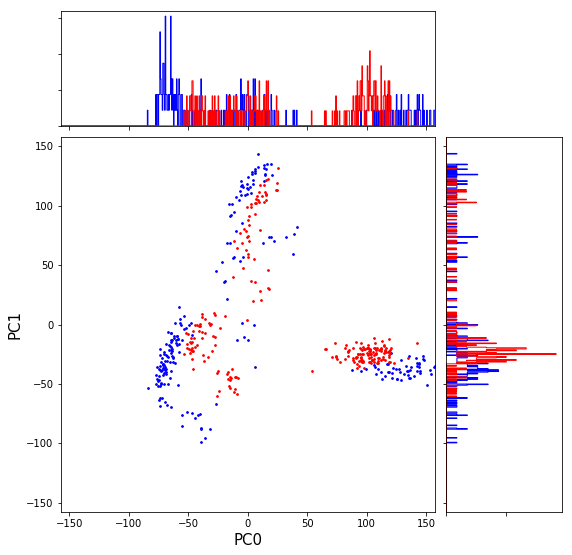

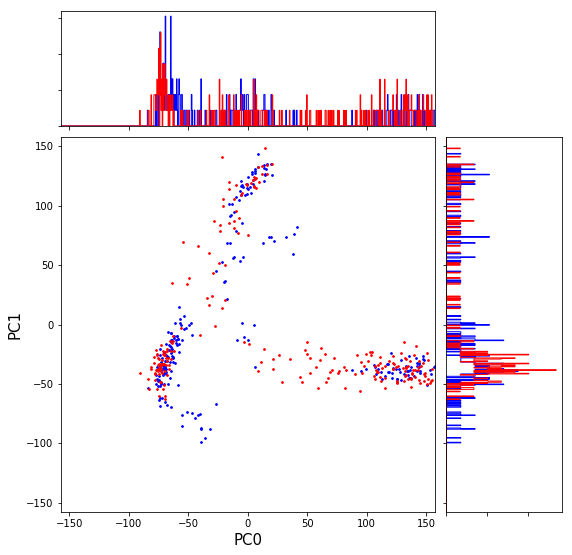

In [11]:
%matplotlib inline
calibratedSource = calibMMDNet.predict(source)

##################################### qualitative evaluation: PCA #####################################
pca = decomposition.PCA()
pca.fit(target)

# project data onto PCs
target_sample_pca = pca.transform(target)
projection_before = pca.transform(source)
projection_after = pca.transform(calibratedSource)

# choose PCs to plot
pc1 = 0
pc2 = 1
axis1 = 'PC'+str(pc1)
axis2 = 'PC'+str(pc2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_before[:,pc1], 
               projection_before[:,pc2], axis1, axis2)
sh.scatterHist(target_sample_pca[:,pc1], target_sample_pca[:,pc2], projection_after[:,pc1], 
               projection_after[:,pc2], axis1, axis2)

In [14]:
import pandas as pd

In [18]:
df = pd.DataFrame(calibratedSource)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-1030.397217,116.956238,-24.756664,36.482510,14.636047,113.054832,3.783360,-13.388974,-52.223682,14.244246,2.281013,6.735566,-12.294495,17.509932,-13.125750,19.051702,-9.061273,12.374686,6.873326,-31.729877
1,-1015.684265,106.432388,-17.772392,14.510221,-42.394218,80.598892,4.737513,12.784771,-28.402222,3.233647,-2.018941,0.717971,-14.693419,-1.156446,-22.311472,9.644553,-13.912382,-2.430179,-0.259534,-31.312822
2,-1015.193176,98.158257,-16.531605,48.979218,-9.288443,120.342255,-6.064445,-22.765110,-47.835804,12.636724,-8.009827,-2.091998,-10.230174,23.904194,-3.574835,4.020576,-5.107115,9.302825,-0.134223,-35.062046
3,-977.149780,107.613304,-10.468987,-10.043771,-79.359161,45.335022,7.180698,68.413132,-0.385188,-20.402424,-13.632198,8.114880,-31.823696,-11.867014,-18.467627,9.109752,14.082269,9.250869,17.469173,-10.090256
4,-993.388428,107.657272,-13.698326,-21.017424,-61.984283,27.679726,19.247128,54.906902,11.942543,-23.801102,6.667124,-2.618947,-13.682047,-26.537014,-14.888954,6.367545,9.454046,7.768825,9.040798,-24.924173
5,-1013.454041,96.522186,-12.008476,50.197296,-12.357950,97.418694,-10.527800,9.826134,-57.412998,6.980206,-12.887912,6.467970,-4.670582,12.524205,-14.491233,3.986859,-16.899284,-0.658319,1.065358,-23.989832
6,-1010.425232,96.985306,1.348618,77.601318,-6.907720,93.892563,-23.208929,-29.536510,-60.914124,2.396699,-19.919191,-13.498959,4.443521,27.597157,-5.493244,-15.732368,-12.629202,-5.047254,-6.817008,-19.543396
7,-1038.718872,108.953629,-22.392750,66.811264,34.569527,105.121101,-8.368988,-3.347731,-67.558929,9.790114,8.916280,18.423429,-1.634655,25.371078,-13.980455,-21.149971,-2.063577,-7.254108,-3.321933,-17.677002
8,-968.512695,86.654404,-24.789665,13.728220,-55.355000,20.169622,1.208466,99.958504,2.469250,-27.500515,4.927210,26.067055,-38.649151,-1.586854,-19.894863,13.500098,30.172432,13.412123,15.998635,-17.116779
9,-984.611450,97.310287,-8.954887,10.025642,-79.181030,31.937103,-5.214103,69.414780,-22.101954,-23.744701,-1.129013,14.341966,-23.129951,-1.765422,-28.483242,-4.681230,11.684297,1.814704,2.068895,-15.814145


In [19]:
calibratedSourcePath = os.path.join(io.DeepLearningRoot(), 'data/calibratedBatch1-gtex-20PCs.csv')
df.to_csv(calibratedSourcePath)